In [1]:
import yfinance as yf
import datetime as dt
import keras
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import CSVLogger


def Percentage_Accuracy(y_true, y_pred):
    diff = keras.backend.abs(y_true-y_pred)
    correct = keras.backend.less(diff,0.03) 
    return keras.backend.mean(correct) 

In [23]:
data = yf.download("AAPL", start="2000-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [24]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.862170,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.789479,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.801033,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.731713,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.766373,460734400
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.459007,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.856941,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.829674,146266000


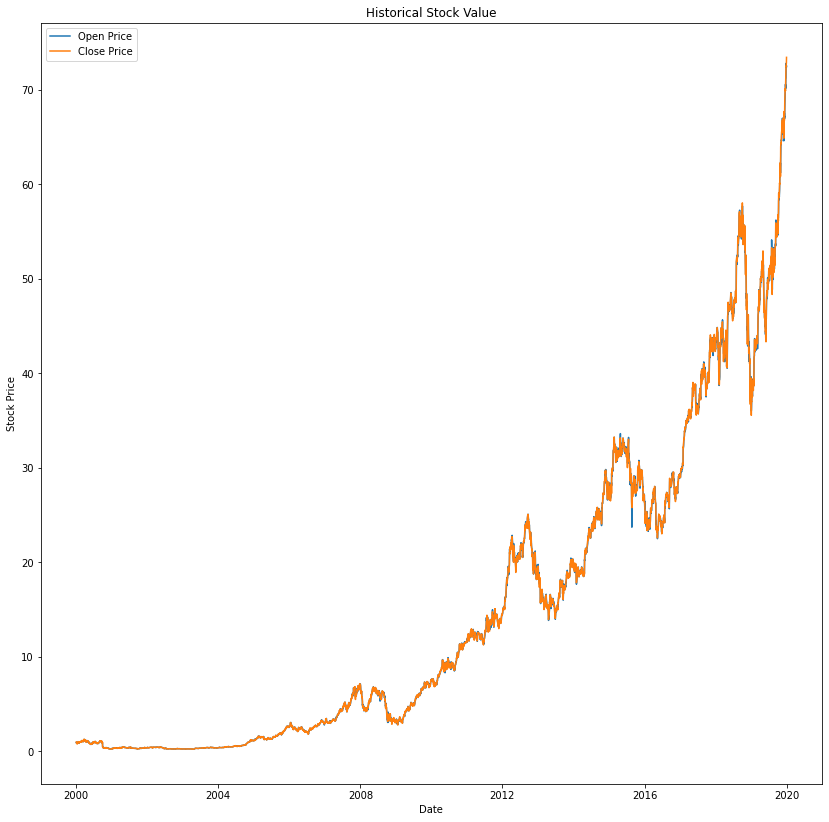

In [25]:
plt.figure(figsize=(14,14))
plt.plot(data['Open'], label='Open Price')
plt.plot(data['Close'], label='Close Price')
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [26]:
data['Date'] = data.index
filter_data = pd.DataFrame(columns = ['Date', 'Open','Volume','Close'])
sc_open = MinMaxScaler(feature_range = (-1, 1))
sc_close = MinMaxScaler(feature_range = (-1, 1))
sc_volume = MinMaxScaler(feature_range=(0,1))
filter_data['Date'] = data['Date']
filter_data['Open'] = sc_open.fit_transform(data.iloc[:,0:1].values)
filter_data['Volume'] = sc_volume.fit_transform(data.iloc[:,5:6].values)
filter_data['Close'] = sc_close.fit_transform(data.iloc[:,3:4].values)
filter_data.reset_index(drop=True)

,Date,Open,Volume,Close
0,2000-01-03,-0.980581,0.067250,-0.979088
1,2000-01-04,-0.979750,0.064077,-0.981391
2,2000-01-05,-0.980858,0.100102,-0.981025
3,2000-01-06,-0.980273,0.098700,-0.983221
4,2000-01-07,-0.982642,0.057082,-0.982123
...,...,...,...,...
5026,2019-12-24,0.955685,0.001238,0.935910
5027,2019-12-26,0.956581,0.007285,0.974446
5028,2019-12-27,1.000000,0.014484,0.973694
5029,2019-12-30,0.988559,0.014193,0.985446


In [27]:
#Training Data
num_entry_train_data = (int)(len(filter_data)*0.7)
X_train = np.empty([num_entry_train_data,2,1])
y_train = []
for i in range(0, num_entry_train_data):
    X_train[i,0,0] = filter_data.iloc[i, 1]
    X_train[i,1,0] = filter_data.iloc[i, 2]
    y_train.append(filter_data.iloc[i, 3])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [28]:
#Test Data
num_entry_test_data = (len(filter_data) - num_entry_train_data)
X_test = np.empty([num_entry_test_data,2,1])
y_test = data.iloc[num_entry_train_data:,3:4].values
for i in range(0, num_entry_test_data):
    index_test = i+num_entry_train_data
    X_test[i,0,0] = filter_data.iloc[index_test, 1]
    X_test[i,1,0] = filter_data.iloc[index_test, 2]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
#Defining the LSTM Recurrent Model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [30]:
#Compiling and fitting the model
csv_logger = CSVLogger("model_history_log.csv")
opt = keras.optimizers.Adamax()
lossfunction = keras.losses.mse
regressor.compile(optimizer = opt, loss = lossfunction, metrics=[Percentage_Accuracy])
regressor.fit(X_train, y_train, epochs = 50, batch_size =16 ,callbacks=[csv_logger], validation_split=0.2)

Epoch 1/50
176/176 [==============================] - 13s 25ms/step - loss: 0.3788 - Percentage_Accuracy: 0.0678 - val_loss: 0.0893 - val_Percentage_Accuracy: 0.0000e+00
Epoch 2/50
176/176 [==============================] - 2s 9ms/step - loss: 0.0109 - Percentage_Accuracy: 0.2192 - val_loss: 0.0778 - val_Percentage_Accuracy: 0.0000e+00
Epoch 3/50
176/176 [==============================] - 2s 9ms/step - loss: 0.0111 - Percentage_Accuracy: 0.2148 - val_loss: 0.0822 - val_Percentage_Accuracy: 0.0000e+00
Epoch 4/50
176/176 [==============================] - 1s 7ms/step - loss: 0.0101 - Percentage_Accuracy: 0.2272 - val_loss: 0.0766 - val_Percentage_Accuracy: 0.0000e+00
Epoch 5/50
176/176 [==============================] - 1s 7ms/step - loss: 0.0101 - Percentage_Accuracy: 0.2285 - val_loss: 0.0664 - val_Percentage_Accuracy: 0.0000e+00
Epoch 6/50
176/176 [==============================] - 1s 7ms/step - loss: 0.0094 - Percentage_Accuracy: 0.2321 - val_loss: 0.0653 - val_Percentage_Accuracy: 0

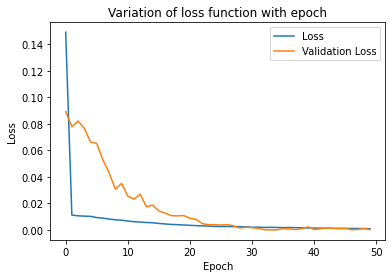

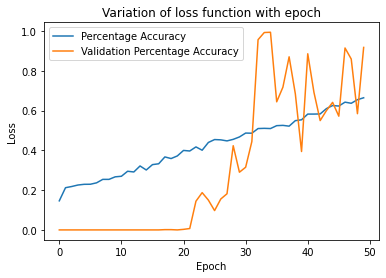

In [31]:
model_log_data = pd.read_csv("model_history_log.csv")
plt.plot(model_log_data["epoch"].values, model_log_data["loss"].values, label = "Loss")
plt.plot(model_log_data["epoch"].values, model_log_data["val_loss"].values, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss function with epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
plt.plot(model_log_data["epoch"].values, model_log_data["Percentage_Accuracy"].values, label = "Percentage Accuracy")
plt.plot(model_log_data["epoch"].values, model_log_data["val_Percentage_Accuracy"].values, label = "Validation Percentage Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss function with epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [32]:
predicted_value = regressor.predict(X_test)

In [33]:
predicted_value = sc_close.inverse_transform(predicted_value)

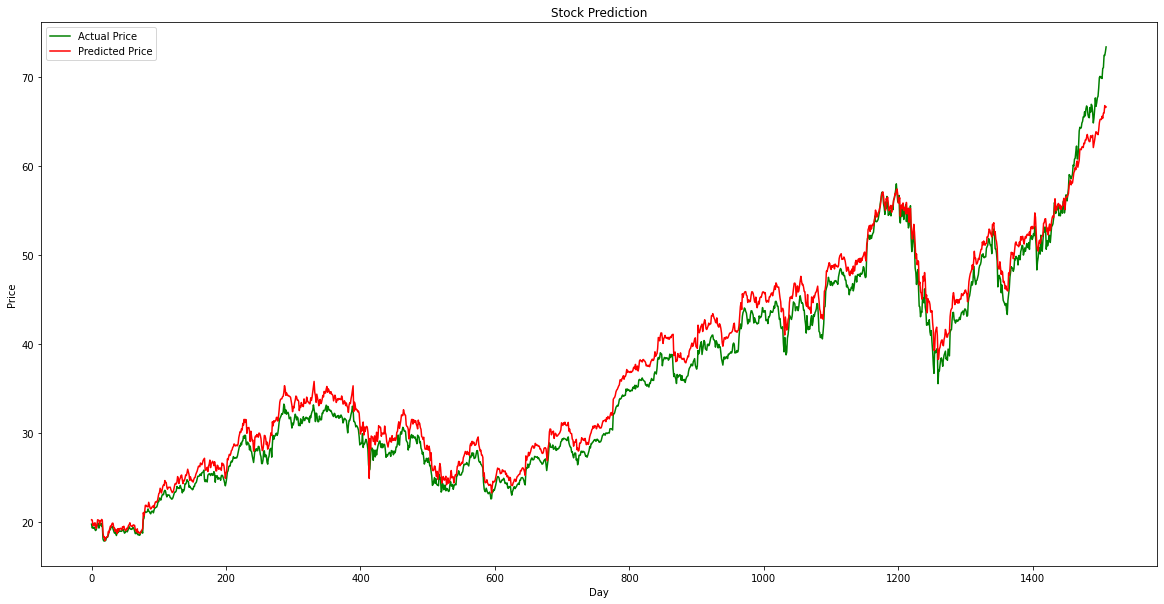

In [34]:
plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'green', label = 'Actual Price')
plt.plot(predicted_value, color = 'red', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()